In [1]:
# Example analysis using the precomputed ScaleFEx vector. The seed was not fixed,
# so the results might differ slightly from the ones published
# NOTE: This cell will download the ScaleFEx pre-computed vector locally
# Data size: 13.2 Gb

from __future__ import print_function
import pandas as pd
import numpy as np
import sklearn
import sklearn.linear_model
import sklearn.ensemble
import glob,string,os,sys
import seaborn as sns
import matplotlib.pyplot as plt

!pip install statannot
from statannot import add_stat_annotation

if not os.path.exists('ScaleFex_computed_normalized.csv'):
    !pip install requests
    import requests
    url = 'https://nyscfopensource.blob.core.windows.net/scalefex/ScaleFex_computed_normalized.csv'
    r = requests.get(url, allow_redirects=True)
    open('ScaleFex_computed_normalized.csv', 'wb').write(r.content)
else:
    print('ScaleFEx data found in the folder')
    



Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
ScaleFEx data found in the folder


In [63]:
Vecs=pd.read_csv('ScaleFex_computed_normalized.csv',index_col=0) 
Vecs

,well,Site,Cell_ID,Close_Cell_1,Close_Cell_2,CoordX,CoordY,plate,RowPos,ColPos,...,Correlation_ch2_ch3,Correlation_Slope_ch2_ch3,Correlation_Overlap_ch2_ch3,Correlation_Mander1_ch2_ch3,Correlation_Mander2_ch2_ch3,Correlation_RWC1_ch2_ch3,Correlation_RWC2_ch2_ch3,Cell_Num,Empty,Usable
0,r03c03,1,3.0,437.778483,1004.390362,1808.0,1762.0,1,C,3,...,0.098982,0.136484,0.910989,0.249314,0.251581,0.241376,0.268577,19.0,False,True
1,r03c03,1,4.0,437.778483,607.148252,1383.0,1657.0,1,C,3,...,0.392797,0.110787,0.878945,0.513743,0.177740,0.260102,0.099216,19.0,False,True
2,r03c03,1,7.0,136.883162,560.358814,992.0,1134.0,1,C,3,...,0.455243,0.101485,0.869132,0.354624,0.252274,0.204741,0.160600,19.0,False,True
3,r03c03,1,8.0,366.132490,466.641190,433.0,1095.0,1,C,3,...,0.240064,0.130300,0.917804,0.249929,0.209499,0.225229,0.208178,19.0,False,True
4,r03c03,1,9.0,150.920509,448.688088,1313.0,367.0,1,C,3,...,0.281201,0.105900,0.871406,0.327469,0.227029,0.201128,0.153753,19.0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485771,r14c22,49,18.0,307.043971,470.991507,1667.0,1356.0,5,N,22,...,0.194545,0.138770,0.910427,0.511785,0.572504,0.260575,0.321424,29.0,False,True
485772,r14c22,49,22.0,333.016516,366.885541,567.0,699.0,5,N,22,...,0.072596,0.166663,0.927322,0.440055,0.369261,0.158097,0.146283,29.0,False,True
485773,r14c22,49,24.0,207.617437,295.949320,1229.0,341.0,5,N,22,...,0.018340,0.128500,0.895662,0.317117,0.057615,0.296576,0.059416,29.0,False,True
485774,r14c22,49,25.0,366.885541,378.033067,890.0,873.0,5,N,22,...,0.317877,0.131894,0.901501,0.326468,0.274632,0.169066,0.156823,29.0,False,True


In [64]:
## Select the columns to use for the analysis and as indexes and data pre-processing
cols=Vecs.columns[21:-3]
index_cols=Vecs.columns.drop(cols)
index_cols_mean=index_cols.drop(['Cell_ID','Close_Cell_1','Close_Cell_2','CoordX','CoordY','Site','Cell_Num','Usable','Empty'])
index_cols_sum=index_cols.drop(['Cell_ID','Close_Cell_1','Close_Cell_2','CoordX','CoordY','Cell_Num','Usable','Empty'])


In [65]:
def well_average_norm_confounded(Emb,cols=np.arange(320).astype(str),group=['Well', 'Plate', 'cmpd_assignment_number','Cmd_Pathway','Treatment'],norm_by=['plate','batch','Row','Col','DonorID']):
    '''Removes confounders contributions from the screen and normalize the values
        cols: list of columns to be normalized and corrected
        group: list of columns for grouping the data
        norm_b: list of confounders to be removed
        '''
    if len(group)>0:
        Embmean=Emb.groupby(group).mean().reset_index()
    else:
        Embmean=Emb
    for i in cols:
        for norm in norm_by:
            for cond in np.unique(Embmean[norm]):
                
                Embmean.loc[(Embmean[norm]==cond),i]=Embmean.loc[(Embmean[norm]==cond),i]-Embmean.loc[(Embmean[norm]==cond),i].mean()

        Embmean[i]=(Embmean[i]-Embmean[i].min())/(Embmean[i]-Embmean[i].min()).max() 
       
    return Embmean

In [66]:
# Generate the well-level average of the data and pre-processing
Vecs=Vecs.loc[Vecs.Usable==True]
Vecsum=Vecs.groupby(list(index_cols_sum)).sum()
Vecsum=Vecsum.groupby(list(index_cols_mean)).mean()
Vecsum=Vecsum[['Cell_Num']]
Vecsum=Vecsum.rename(columns={'Cell_Num':'well_counts'}) # computes the total number of cells per well
Vecmean=well_average_norm_confounded(Vecs,cols=cols,group=list(index_cols_mean),norm_by=['plate','donor_id','RowPos','ColPos'])
Vecmean=Vecmean.merge(Vecsum,on=list(index_cols_mean))
Vecmean=Vecmean.fillna(0).reset_index()


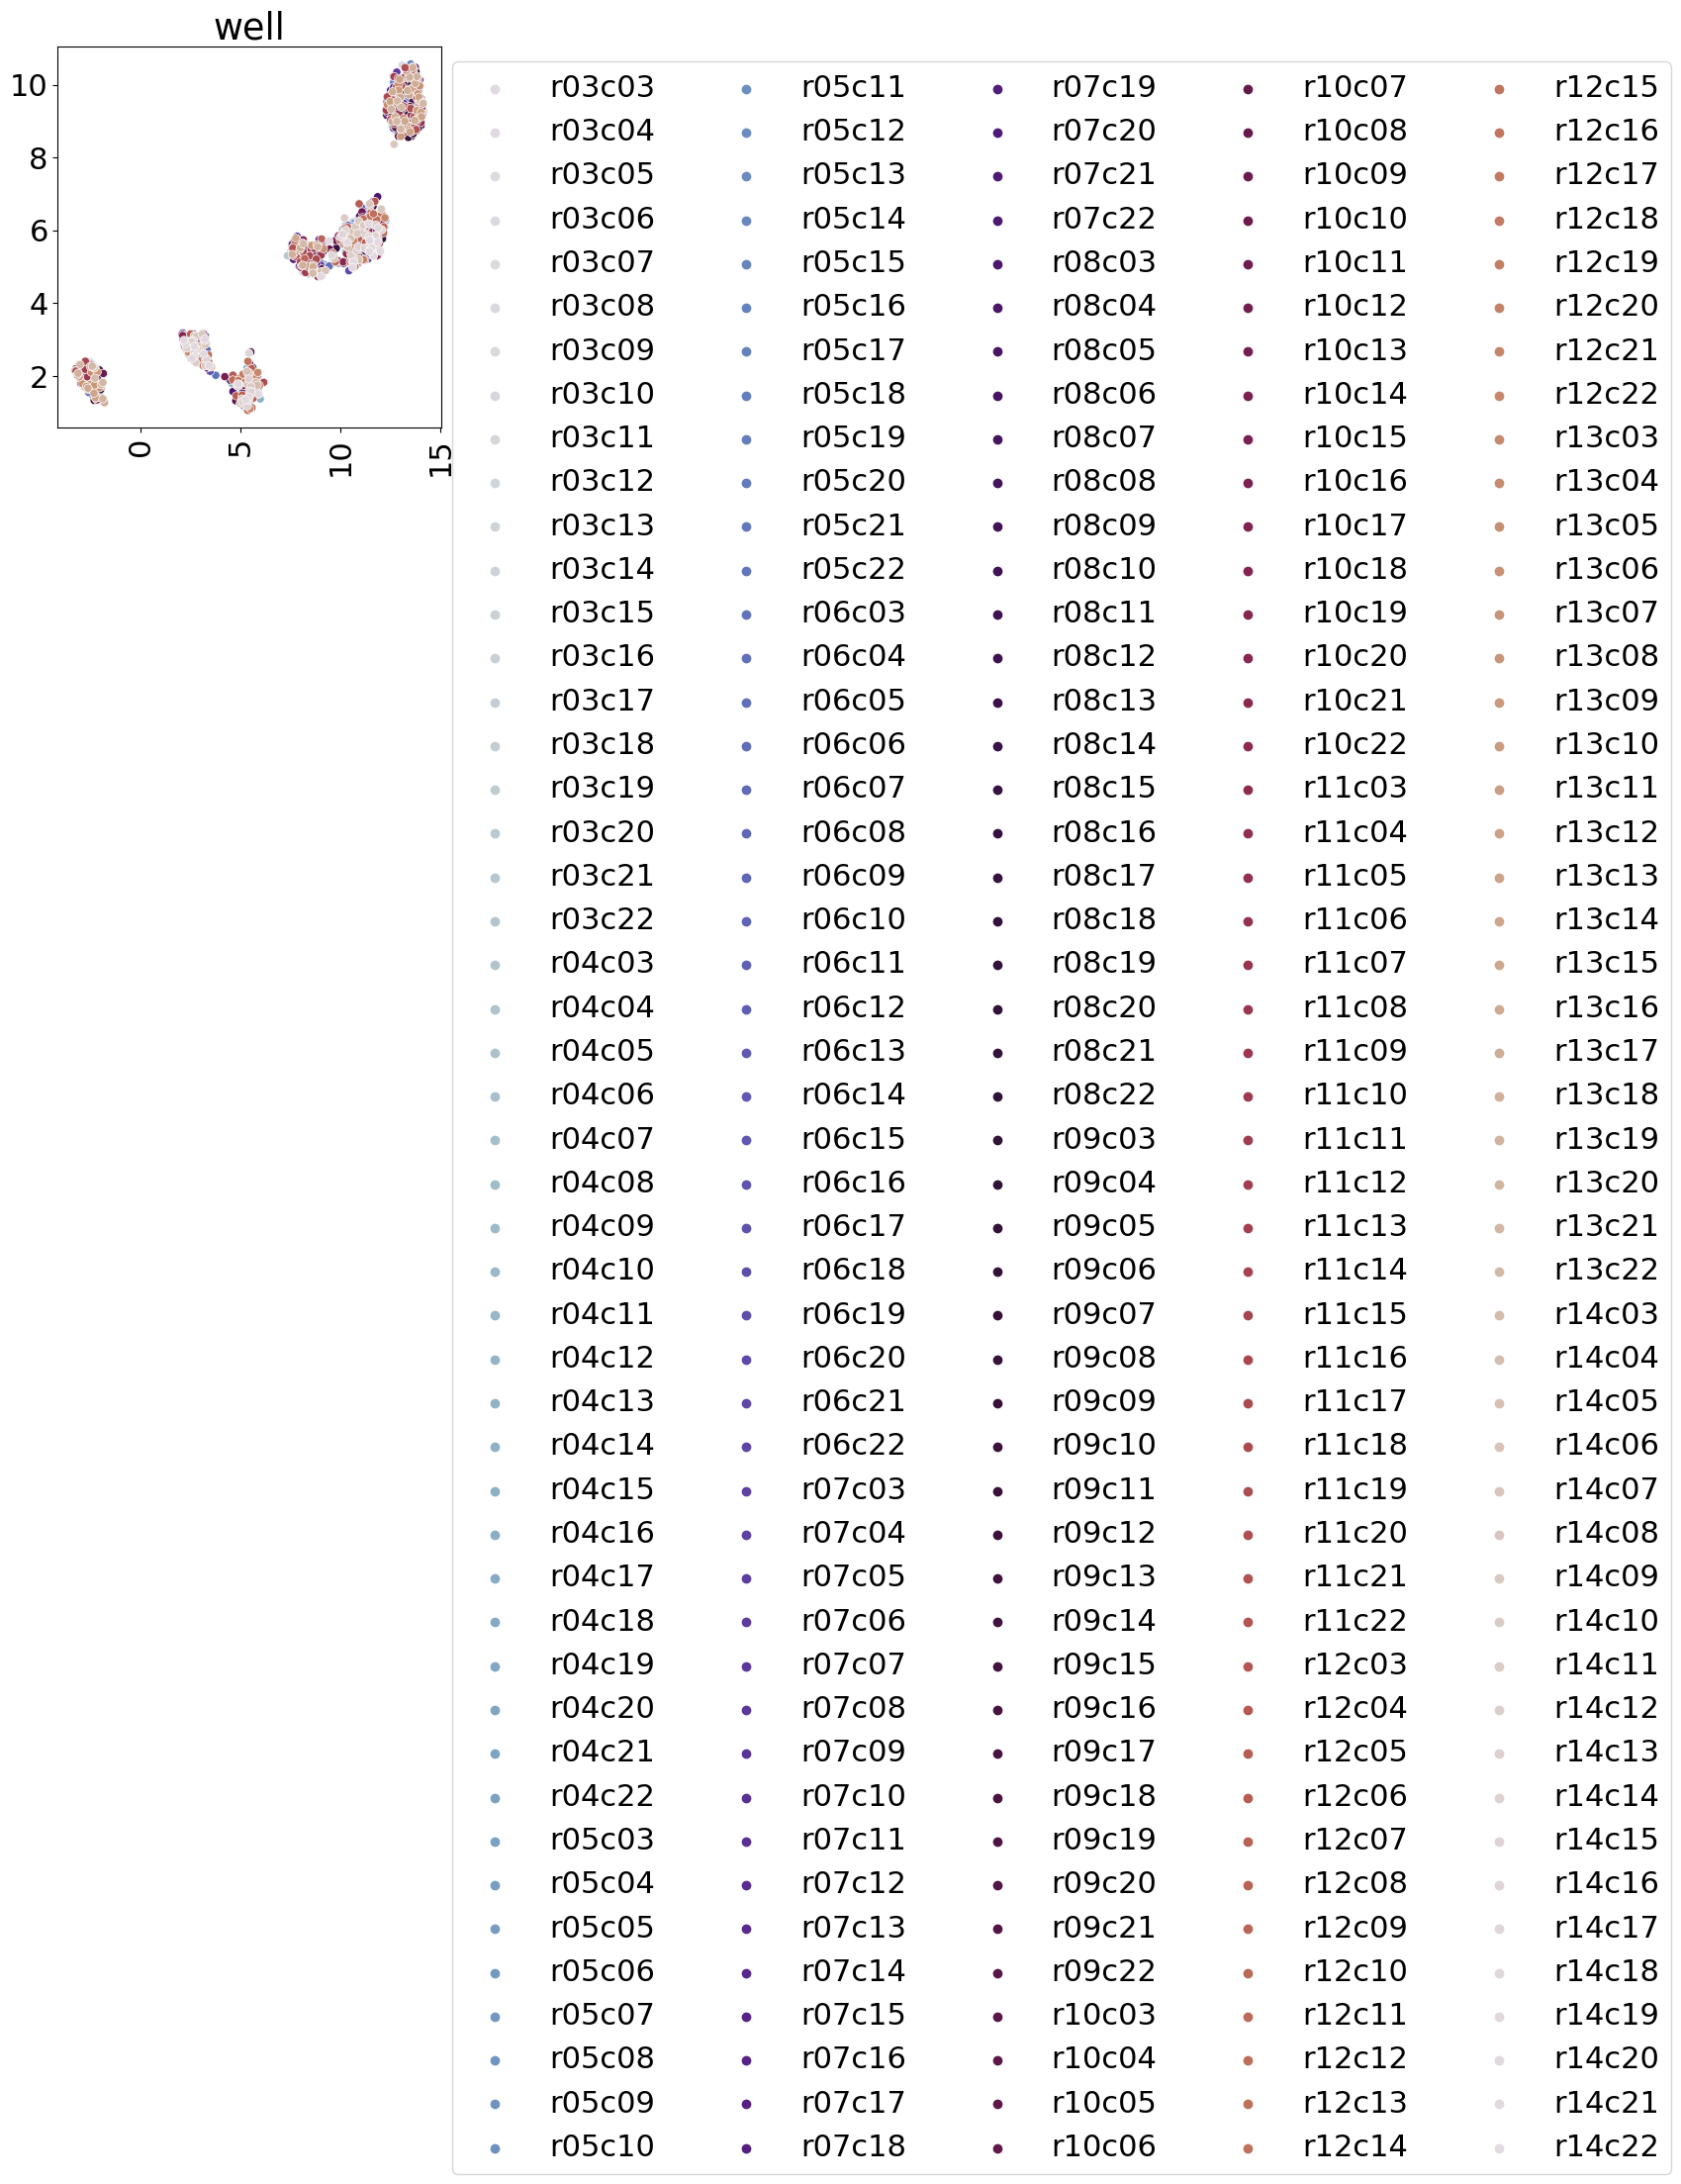

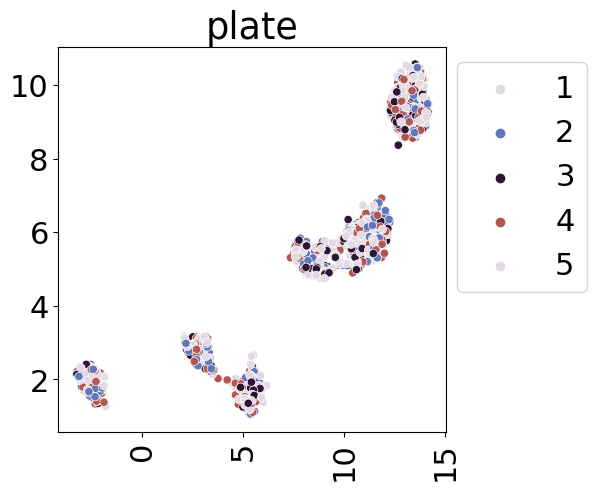

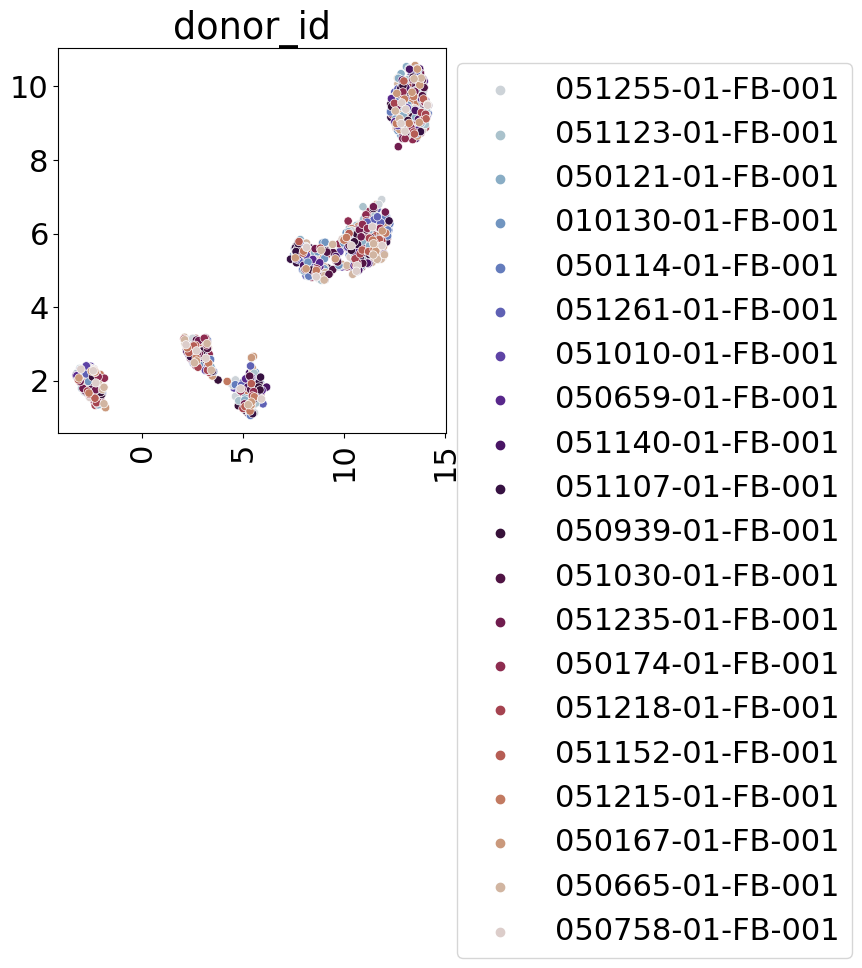

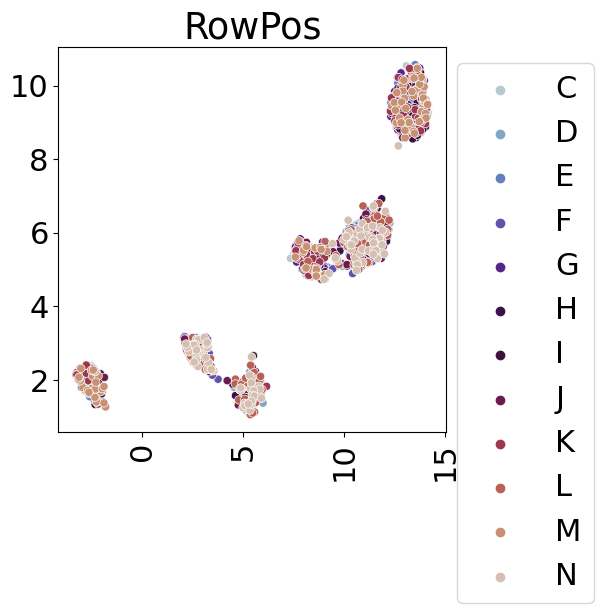

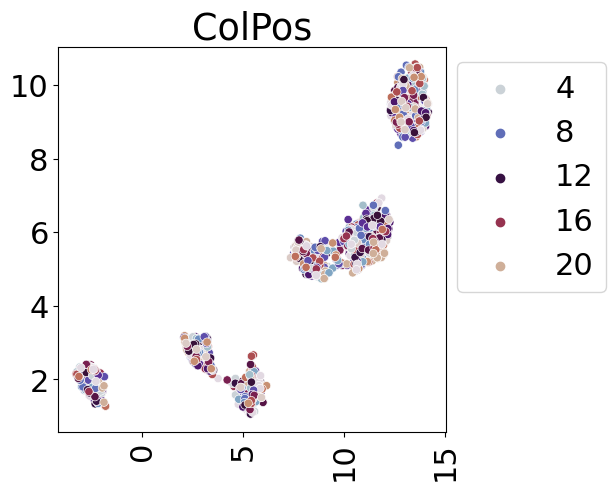

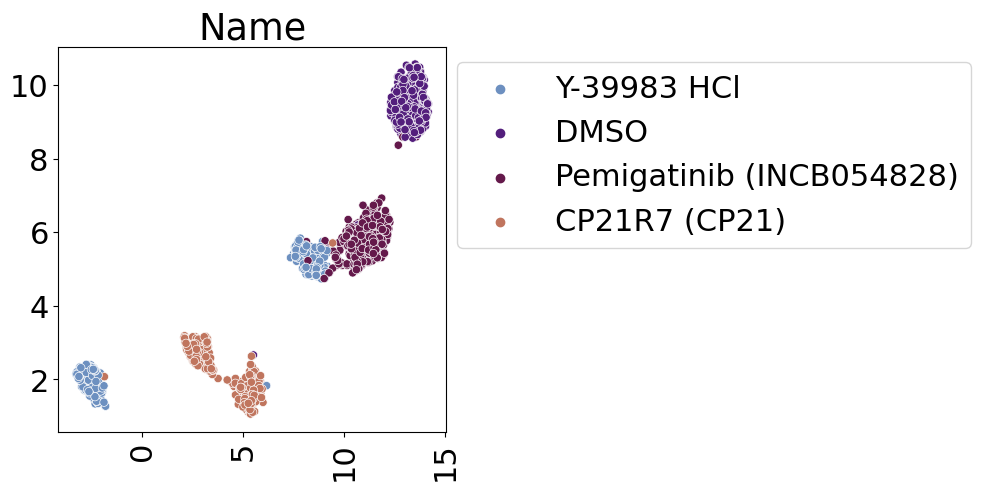

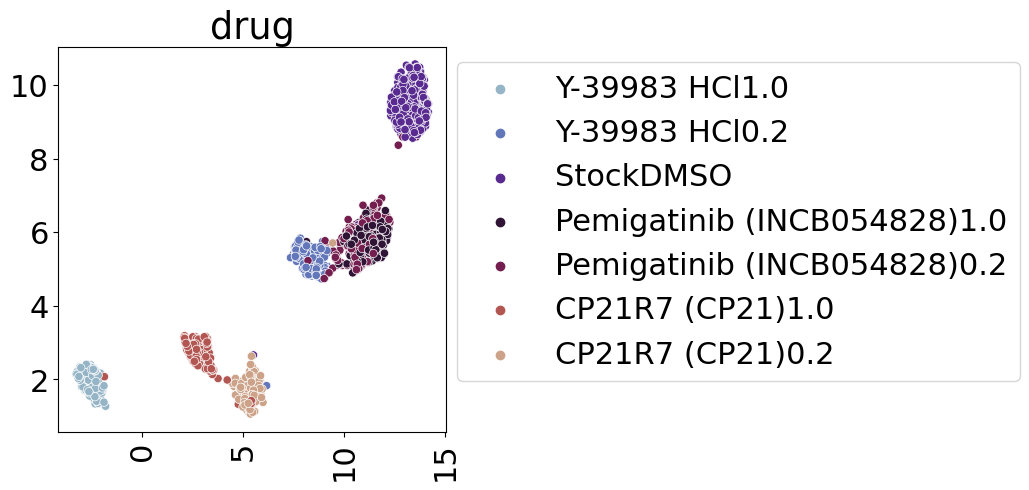

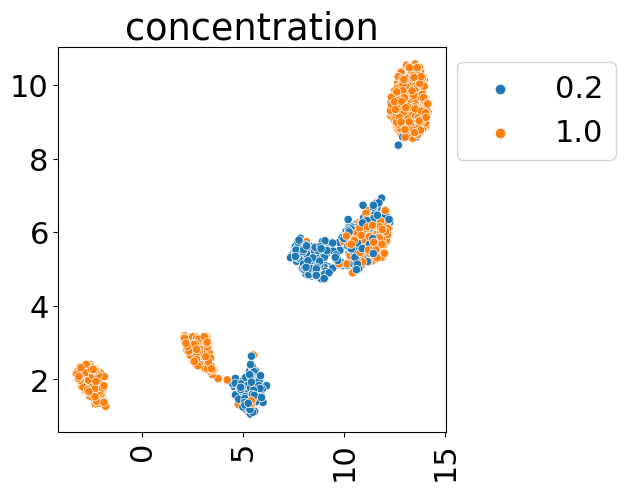

In [67]:
##Make a UMAP to see how the confounders and the signal cluster among each other
import umap.umap_ as umap

embedding = umap.UMAP(n_neighbors=50,
                      min_dist=0.01,
                      metric='correlation').fit_transform(Vecmean[list(cols)])
for col in ['well','plate','donor_id','RowPos','ColPos','Name','drug','concentration']:
    plt.subplots(figsize = (5,5))
    pal='twilight'
    if col=='well_counts':
        pal='Blues'
    elif col=='Cell_Num':
        pal='Reds'
    elif col=='concentration':
        pal='tab10'
    ncol=1
    if col=='well':
        ncol=5
    
    sns.scatterplot(x=embedding[:,0],y=embedding[:,1],hue=Vecmean[col],palette=pal)
    plt.legend(bbox_to_anchor=(0.99, 1), loc='upper left',ncol=ncol)
    plt.title(col)
    
    plt.xticks(rotation=90)


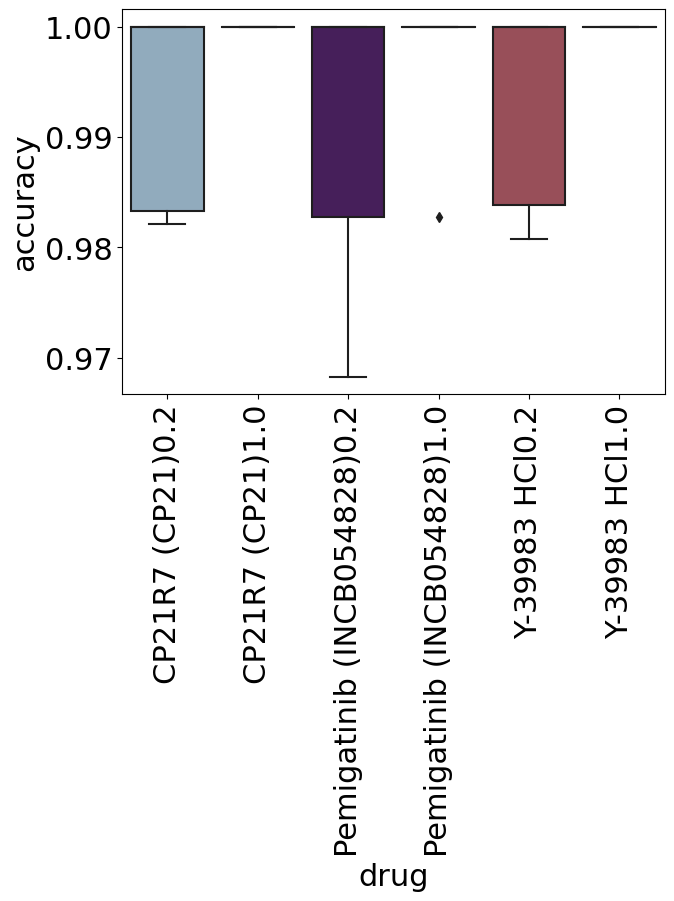

In [69]:
### Linear regression features sort
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
# fit the model

model.fit(Vecmean[cols], Vecmean['drug_id'])
features_LR={}   
Results=pd.DataFrame(columns=['plate','drug','accuracy'])
for i in np.unique(Vecmean['drug']):
    if i != 'StockDMSO':
        features_LR[i]=pd.DataFrame(columns=cols)
        temp=Vecmean.loc[Vecmean['drug']==i]
        temp=pd.concat([temp,Vecmean.loc[Vecmean['drug']=='StockDMSO']]).reset_index()
        temp['drug_id']=0
        temp.loc[temp.drug!='StockDMSO','drug_id']=1
        temp=temp.drop(temp.loc[temp.drug_id==0].sample(len(temp.loc[temp.drug_id==1])).index)
        for plate in np.unique(temp.plate):
            model.fit(temp.loc[temp.plate!=plate][cols], temp.loc[temp.plate!=plate].drug_id.values)
            features_LR[i].loc[plate]=model.coef_
            temp2=[plate,i,sklearn.metrics.accuracy_score(temp.loc[temp.plate==plate]['drug_id'],np.round(model.predict(temp.loc[temp.plate==plate][cols])))]
            Results=pd.concat([Results,pd.DataFrame(np.asarray(temp2).reshape(1,3),columns=['plate','drug','accuracy'])],axis=0)
Results['accuracy']=Results['accuracy'].astype(float)
plt.subplots(figsize=(7,5))

sns.boxplot(data=Results,y='accuracy',x='drug',palette='twilight')
_=plt.xticks(rotation=90)

_=plt.xticks(rotation=90)

In [70]:
### Variance thresholding: removes the columns with low variance
from sklearn.feature_selection import VarianceThreshold
X = Vecmean[cols]
print(X.shape)
sel = VarianceThreshold()
X=sel.fit_transform(X)
print(X.shape)
cols_red=sel.get_feature_names_out()

(1200, 1733)
(1200, 1690)


In [71]:
def correlation(dataset, threshold):
    ''' Finds correlated features (over the set threshold) and groups them
        Returns:

        dataset2: dataset composed of uncorrelated features
        col_corr2: grouped correlated features
        dataset2.columns: features to be kept as they are uncorrelated

        '''
    col_corr = [] # Set of all the names of deleted columns
    col_corr2={}
    uncorr=[]
    corr_matrix = dataset.corr()
    dataset2=corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    n=0
    for i in corr_matrix.columns:
        
        if (any(np.abs(dataset2[i]) >= threshold)):
            
            col_corr.append(i)
            tem=dataset2[i][dataset2[i]>threshold].index
            col_corr2[n]=tem

            dataset2=dataset2.drop(i,axis=1) # deleting the column from the dataset
            dataset2=dataset2.drop(i,axis=0)
   
        else:
            col_corr2[n]=i
            

    return dataset2,col_corr2,dataset2.columns

In [72]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
preds_LR_fin={}
# Create the RFE object and rank each feature without removing correlated features
clf = LogisticRegression(max_iter=100000)
LR = LogisticRegression(max_iter=100000)
model={}
features={}
preds_LR_fin={}
Vecmean=Vecmean.reset_index()
for n,i in enumerate(np.unique(Vecmean.loc[Vecmean.drug!='StockDMSO'].drug)):
    

    model[i]={}
    if i != 'StockDMSO':
        preds_LR_fin[i]=pd.DataFrame()

        n_feat=np.asarray([600, 900, 100, 100, 400, 100])[n] # these numbers were found by looking at the predictions score removing the features one by one sorted by importance
        temp=Vecmean.loc[Vecmean.drug==i]
        temp=pd.concat([temp,Vecmean.loc[Vecmean.drug=='StockDMSO']])
        temp['drug_id']=0
        temp.loc[temp.drug!='StockDMSO','drug_id']=1
        temp=temp.drop(temp.loc[temp.drug_id==0].sample(len(temp.loc[temp.drug_id==1])).index)
        accuracy=[]
        auc=[]
        lenF=[]
        for plate in np.unique(Vecmean.plate):
            X_train=temp.loc[temp.plate!=plate][cols_red]
            y_train=temp.loc[temp.plate!=plate]['drug_id']

            X_test=temp.loc[temp.plate==plate][cols_red]
            y_test=temp.loc[temp.plate==plate]['drug_id']
            rfe = RFE(estimator=clf, n_features_to_select=n_feat)
            LR = LogisticRegression(max_iter=100000)
            rfe.fit(X_train, y_train)

            # Get the mask of selected features
            mask = rfe.support_

            
            RFE_cols=X_train.columns[mask]
            # Get the final list of important and non-correlated features
            #_,_,important_non_correlated_features=correlation(X_train[RFE_cols],0.9)
            important_non_correlated_features=RFE_cols
            lenF.append(len(important_non_correlated_features))
            # Select only the important and non-correlated features
            X_test = X_test[important_non_correlated_features]
            LR.fit(X_train[important_non_correlated_features],y_train)
            model[i][plate]=LR
            features[i]=important_non_correlated_features
            auc.append(sklearn.metrics.roc_auc_score(y_test,LR.predict(X_test[important_non_correlated_features])))
            accuracy.append(sklearn.metrics.accuracy_score(y_test,LR.predict(X_test[important_non_correlated_features])))

        t2=pd.DataFrame()
        t2.loc[n,'drug']=i
        t2.loc[n,'feat_parameter']=n_feat
        #t2.loc[n,'final_parameter_n']=np.mean(lenF)
        t2.loc[n,'Accuracy']=np.mean(accuracy)
        t2.loc[n,'AUC']=np.mean(auc)
        preds_LR_fin[i]=pd.concat([preds_LR_fin[i],t2])
        print(preds_LR_fin[i])

               drug  feat_parameter  Accuracy       AUC
0  CP21R7 (CP21)0.2           600.0   0.99661  0.996552
               drug  feat_parameter  Accuracy  AUC
1  CP21R7 (CP21)1.0           900.0       1.0  1.0
                          drug  feat_parameter  Accuracy       AUC
2  Pemigatinib (INCB054828)0.2           100.0  0.993218  0.993333
                          drug  feat_parameter  Accuracy       AUC
3  Pemigatinib (INCB054828)1.0           100.0  0.992982  0.992593
             drug  feat_parameter  Accuracy       AUC
4  Y-39983 HCl0.2           400.0  0.993103  0.992857
             drug  feat_parameter  Accuracy  AUC
5  Y-39983 HCl1.0           100.0       1.0  1.0


In [73]:
def add_channel_features(feat):
    ''' This function extracts from the list 'feat' the categories of the features'''
    a=[]
    for n in range(1,6):
        if 'ch'+str(n) in feat:
            a.append(['ER','Mito','AGP','DNA','RNA'][n-1])
    if 'Mito' in feat:
        a.append('Mito')
    if 'RNA' in feat:
        a.append('RNA')
    if len(a)==0:
        a.append('None')
    return a


CP21R7 (CP21)0.2 True


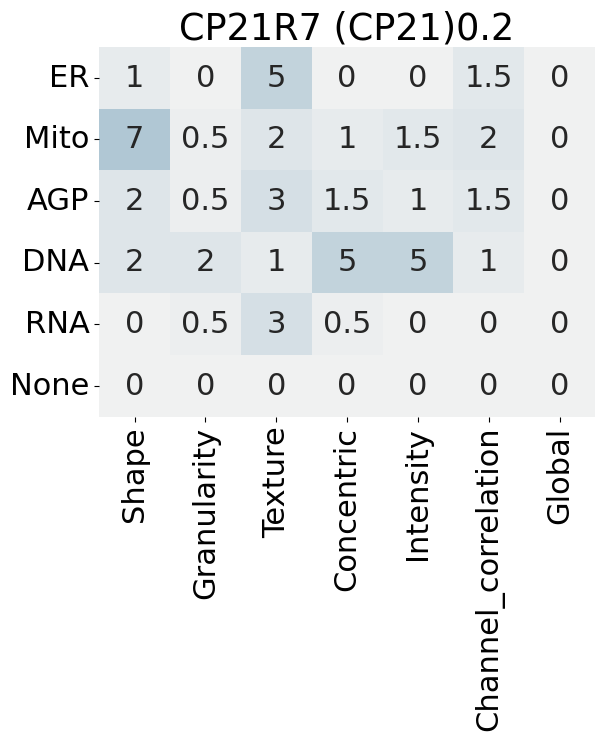

CP21R7 (CP21)1.0 True


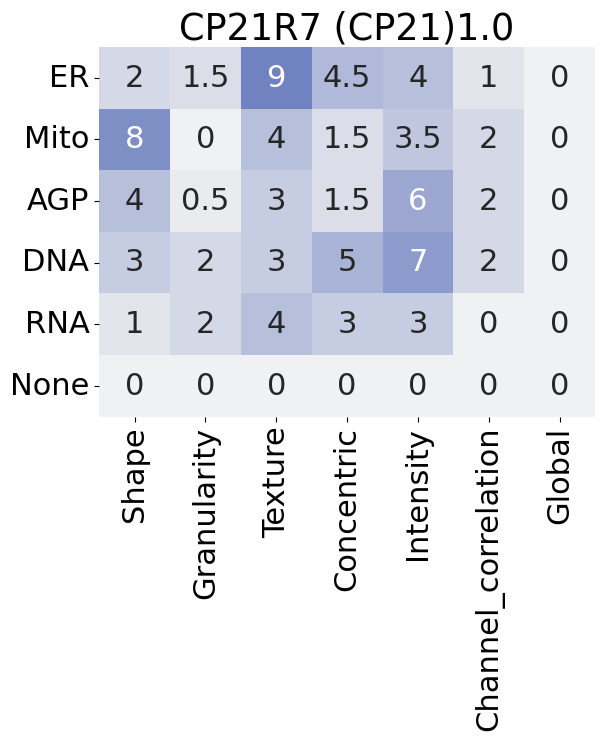

Pemigatinib (INCB054828)0.2 True


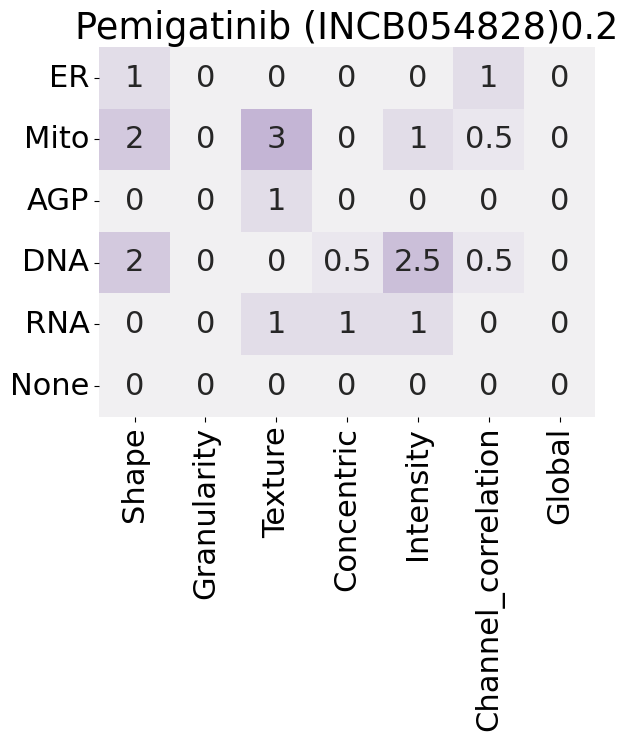

Pemigatinib (INCB054828)1.0 True


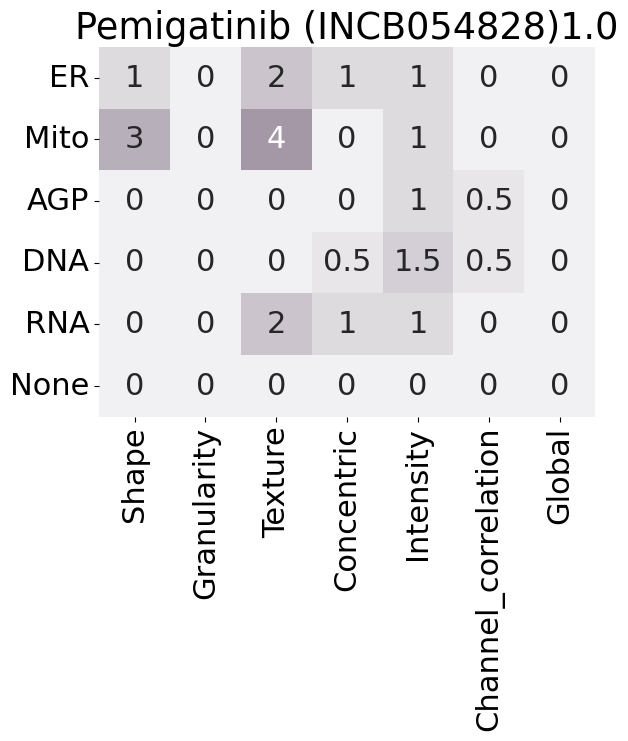

Y-39983 HCl0.2 True


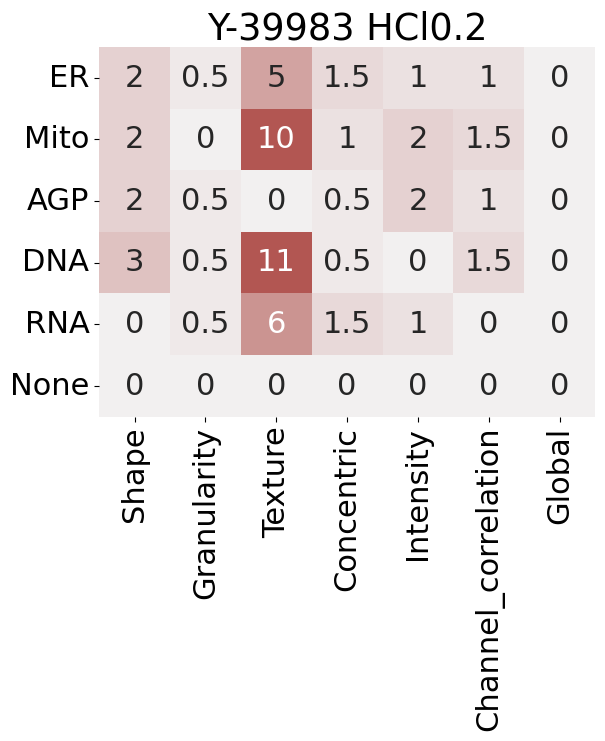

Y-39983 HCl1.0 True


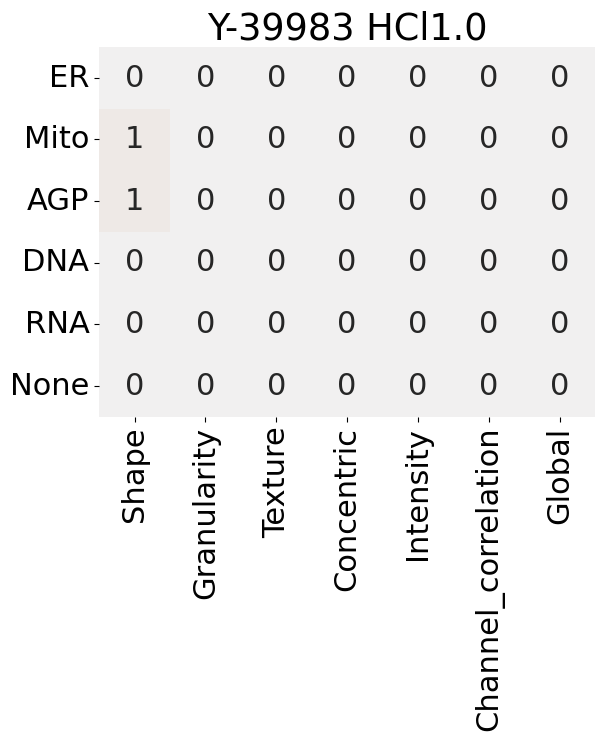

In [43]:
### remove correlated features after putting the 5 CVs together
pale=sns.color_palette("twilight",7).as_hex()
tot_features_summary={}
for n,i in enumerate(np.unique(Vecmean.drug)):
    if i!='StockDMSO':
        a=pd.DataFrame()
        f=0
        #i='Pemigatinib (INCB054828)1.0'
        for f,key in enumerate(model[i].keys()):
            if f==0:

                a['features']=model[i][key].feature_names_in_
                a['coefficient_Plate1']=model[i][key].coef_[0]


            else:
                a['coefficient_Plate'+str(f+1)]=0
                for feat in model[i][key].feature_names_in_:


                    if feat in list(a.features.values):

                        a.loc[a.features==feat,'coefficient_Plate'+str(f+1)]=model[i][key].coef_[0][np.where(feat==model[i][key].feature_names_in_)[0]][0]
                    else:
                        #print(feat)
                        temp=np.zeros((1,f+2)).astype(object)
                        temp[0][0]=feat
                        temp[0][f+1]=model[i][key].coef_[0][np.where(feat==model[i][key].feature_names_in_)[0]][0]
                        a=pd.concat([a,pd.DataFrame(temp,columns=a.columns,index=[a.index[-1]+1])])

        a['sum_of_coefficients']=abs(a.iloc[:,1:]).sum(axis=1)
        a['total_counts']=(a.iloc[:,1:-1]!=0.0).sum(axis=1)   
        d,e,g=correlation(X_train[a.features],0.9)
        
        a=a[a.features.isin(g)]
        
        tot_features_summary[i]=a
        feat_bar=pd.DataFrame(0,columns=['Shape','Granularity','Texture','Concentric','Intensity','Channel_correlation','Global'],index=['ER','Mito','AGP','DNA','RNA','None'])
        
        for ff in a.loc[a.total_counts==5].features:
            b=[]
            if ("intensity" in ff) or ("Int" in ff):# or ("int" in ff) :
                 b.append('Intensity')

            if ("Solidity" in ff) or ('Perimeter' in ff) or ('hape' in ff) or ("Eccentricity" in ff) or ('RNA' in ff) or ('Mito' in ff):
                 b.append('Shape')

            if ('Granularity' in ff):
                 b.append('Granularity')

            if ("ext" in ff) :
                 b.append('Texture')

            if ('Conc' in ff) :
                 b.append('Concentric')
            if ('Mander' in ff) or ('Slope' in ff) or ('Overlap' in ff) or ('RWC' in ff) or ('Correlation_c' in ff):
                b.append('Channel_correlation')
            if len(b)==0:
                print(b)
                b.append('Global')

            for c in add_channel_features(ff):
                for bb in b:
                    feat_bar.loc[c,bb]+=1/(len(b)+len(add_channel_features(ff))-1)

        print(i,len(a.loc[a.total_counts==5].features)==feat_bar.sum().sum())
        cmap=sns.light_palette(pale[n], as_cmap=True)


        sns.heatmap(feat_bar,annot=True,vmax=10,cmap=cmap,cbar=False)
        #
        plt.title(i)
        plt.show()


In [ ]:

###Plot single feature distributions compared to controls

pale=sns.color_palette("twilight",7).as_hex()
for r,i in enumerate(tot_features_summary.keys()):
    temp=Vecmean.loc[Vecmean.drug==i]
    temp=pd.concat([temp,Vecmean.loc[Vecmean.drug=='StockDMSO']],axis=0)
    temp2=tot_features_summary[i].loc[tot_features_summary[i].total_counts==5]
    temp2=temp2.sort_values(by='sum_of_coefficients',ascending=False)
    color=['#95b5c7','#6276ba','#592a8f','#2f1436','#b25652','#cca389'][r]
    n=0
    while n<10:
        if len(temp2)>n:
            
            plt.subplots(figsize=(2,2))
            g=sns.boxplot(data=temp,y=temp2.features.iloc[n],x='drug',palette=[color,'#741e4f'])
            add_stat_annotation(g, data=temp, x='drug',y=temp2.features.iloc[n], order=[i,'StockDMSO'],
                    box_pairs=[(i,'StockDMSO')],
                    test='Mann-Whitney', text_format='star',  verbose=0)
            plt.title(i)
            plt.xticks([0,1],['Drug','Control'])
            plt.xlabel('')
            plt.show()
            n+=1
        else:
            break


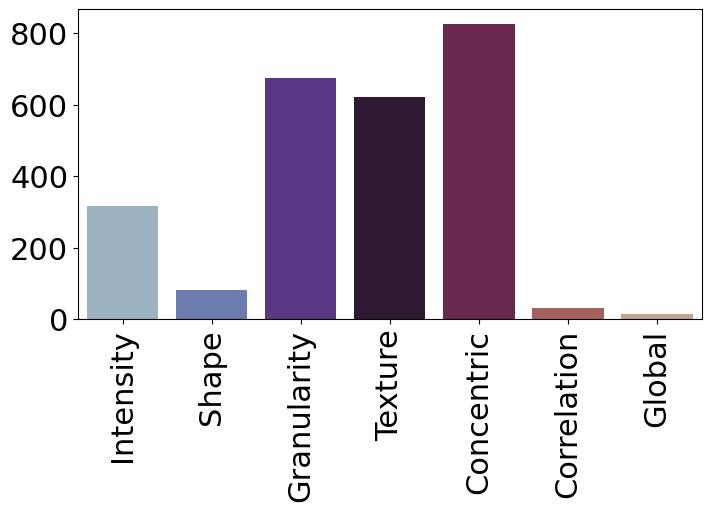

In [45]:
## Sum the categories of the main features
cats=pd.DataFrame(np.zeros((1,7)),columns=['Intensity','Shape','Granularity','Texture','Concentric','Correlation','Global'])
for col in Vecmean.columns[9:-14]:
    if 'ntensity' in col:
        cats['Intensity']+=1
    elif ('hape' in col) or ('Mito' in col) or ('RNA' in col):
        cats['Shape']+=1
    elif 'ranularity' in col:
        cats['Granularity']+=1
    elif ('exture' in col) or ('Tex' in col):
        cats['Texture']+=1
    
    elif 'orrelation' in col:
        cats['Correlation']+=1
    else:
        
        cats['Global']+=1
    
    if 'Conc' in col:
        cats['Concentric']+=1

font = {#'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

plt.subplots(figsize=(7,5),constrained_layout=True)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
sns.barplot(data=cats,palette='twilight')
_=plt.xticks(rotation=90)


### Visualize single cells or entire wells closer to the average of the meaningful features

In [46]:
## NOTE: This cell will automatically download and extract the images from a server if not found in this folder.
## if you already downloaded it manually, please place the folder with the images in this folder
## The total size is 142 GBs 


if not os.path.exists('ScaleFEx/'):
    if os.path.exists('ScaleFEx.zip'):
        print('unzipping files')
        !pip install zipfile36

        if sys.version_info >= (3, 6):
            import zipfile
        else:
            import zipfile36 as zipfile
            
        with zipfile.ZipFile('ScaleFEx.zip', 'r') as zip_ref:
            zip_ref.extractall()
    else:
        print('Downloading the images from the server. This might take some time')
        url = 'https://nyscfopensource.blob.core.windows.net/scalefex/ScaleFEx.zip'
        r = requests.get(url, allow_redirects=True)
        open('ScaleFEx.zip', 'wb').write(r.content)
else:
    print('Images found in the path')
fold='ScaleFEx/'

Images found in the path


In [ ]:

## Visualize single cells
import cv2
ROI=35
for r,i in enumerate(tot_features_summary.keys()):
    tempDrug=Vecmean.loc[Vecmean.drug==i]
    tempDMSO=Vecmean.loc[Vecmean.drug=='StockDMSO']
    
    temp2=tot_features_summary[i].loc[tot_features_summary[i].total_counts==5]
    temp2=temp2.sort_values(by='sum_of_coefficients',ascending=False).features
    tempSCDrug=Vecs.loc[Vecs.drug==i]
    tempSCDMSO=Vecs.loc[Vecs.drug=='StockDMSO']
    for f in temp2[:5]:
        temp3=abs(tempSCDrug[f]-tempDrug[f].median())
        temp3=temp3.sort_values()
        fig,ax=plt.subplots(2,5,figsize=(15,3))
        ax=ax.ravel()
        for en,ii in enumerate(temp3.iloc[:5].index):
            cell=Vecs.loc[ii]
            cell.CoordX=int(cell.CoordX/4)
            cell.CoordY=int(cell.CoordY/4)
            Well=cell.well
            Site='f'+str(int(cell.Site)).zfill(2)

            plate=cell.plate

            ch=f[-3:]
            if 'ch' not in ch:
                if 'Mito' in f:
                    ch='ch2'
                elif 'RNA' in f:
                    ch='ch5'
                else:
                    ch='ch3'
            if 'ranch' in f:
                ch='ch2'
                
            if f.count('ch')>1:
                img=np.zeros((540,540,3))
                plLoc=glob.glob(fold+'*'+str(plate)+'*/')[0]
                for chc in range(2):
                    if chc==1:
                        img[:,:,chc]=cv2.imread(glob.glob(plLoc+Well+Site+'*'+ch+'*')[0],-1)
                        img[:,:,chc]=img[:,:,chc]/np.quantile(img[:,:,chc],0.99)
                    else:
                        img[:,:,chc]=cv2.imread(glob.glob(plLoc+Well+Site+'*'+f[-7:-4]+'*')[0],-1)
                        img[:,:,chc]=img[:,:,chc]/np.quantile(img[:,:,chc],0.99)
                Img=img[int(cell.CoordX)-ROI:int(cell.CoordX)+ROI,int(cell.CoordY)-ROI:int(cell.CoordY)+ROI]

            else:
                plLoc=glob.glob(fold+'*'+str(plate)+'*/')[0]
                img=cv2.imread(glob.glob(plLoc+Well+Site+'*'+ch+'*')[0],-1)
                Img=img[int(cell.CoordX)-ROI:int(cell.CoordX)+ROI,int(cell.CoordY)-ROI:int(cell.CoordY)+ROI]

            ax[en].imshow(Img,cmap='Greys_r')
            ax[0].set_ylabel('Drug')
            ax[en].axis('off')
        ax[2].set_title(f+'_'+i)
        
        temp3=abs(tempSCDMSO[f]-tempDMSO[f].median())
        temp3=temp3.sort_values()

        for en,ii in enumerate(temp3.iloc[:5].index):
            cell=Vecs.loc[ii]
            cell.CoordX=int(cell.CoordX/4)
            cell.CoordY=int(cell.CoordY/4)
            Well=cell.well
            Site='f'+str(int(cell.Site)).zfill(2)


            plate=cell.plate

            ch=f[-3:]
            if 'ch' not in ch:
                if 'Mito' in f:
                    ch='ch2'
                elif 'RNA' in f:
                    ch='ch5'
                else:
                    ch='ch3'
            if 'ranch' in f:
                ch='ch2'
                
                
            if f.count('ch')>1:
                img=np.zeros((540,540,3))
                plLoc=glob.glob(fold+'*'+str(plate)+'*/')[0]
                for chc in range(2):
                    if chc==1:
                        img[:,:,chc]=cv2.imread(glob.glob(plLoc+Well+Site+'*'+ch+'*')[0],-1)
                        img[:,:,chc]=img[:,:,chc]/np.quantile(img[:,:,chc],0.99)
                    else:
                        img[:,:,chc]=cv2.imread(glob.glob(plLoc+Well+Site+'*'+f[-7:-4]+'*')[0],-1)
                        img[:,:,chc]=img[:,:,chc]/np.quantile(img[:,:,chc],0.99)
                Img=img[int(cell.CoordX)-ROI:int(cell.CoordX)+ROI,int(cell.CoordY)-ROI:int(cell.CoordY)+ROI]
            else:
                plLoc=glob.glob(fold+'*'+str(plate)+'*/')[0]
                img=cv2.imread(glob.glob(plLoc+Well+Site+'*'+ch+'*')[0],-1)
                Img=img[int(cell.CoordX)-ROI:int(cell.CoordX)+ROI,int(cell.CoordY)-ROI:int(cell.CoordY)+ROI]

            ax[en+5].imshow(Img,cmap='Greys_r')
            ax[en+5].axis('off')

            ax[5].set_ylabel('DMSO')
  
               

In [21]:
def stitch_single_well_multicoloTrue(well,singleChannels,Path,color_scale=[],sizeFx=2160, sizeFy=2160, tilesx=7, tilesy=7,vmax='Def',Fields=[], fac=4,empty_tiles=[]):
    sizeFx=int(sizeFx/fac)
    sizeFy=int(sizeFy/fac)
    if len(singleChannels)>1:
        TotWell = np.zeros((sizeFy * tilesy, sizeFx * tilesx,3))
    else:
        TotWell = np.zeros((sizeFy * tilesy, sizeFx * tilesx,1))
    #B=Df.loc[Df.well==well+'_'].sort_values(by='Site').Usable.values
    p = 0
    o = 0

    for i in range((tilesx * tilesy)):
        if i in empty_tiles:
            o += sizeFx
        else:
            #if B[Fields[i]]==True:
            for n,j in enumerate(singleChannels):
                #A = glob.glob(Path + '/*%s' % well + '_Site%s_*' % str(Fields[i]).zfill(3)+j+'.tiff')#NIkon
                A = glob.glob(Path + '/*%s' % well + 'f%s*' % str(Fields[i]).zfill(2)+j+'*.tiff')#Phoenix
                #B = glob.glob(Path + '/*%s' % well + '_Site%s_CY5c1*' % str(Fields[f]).zfill(3))
                #print(A)
                if len(A) > 0:
                    A = A[0]

                if len(A) > 5:
                    imgDAPI = cv2.imread(A, -1)

                    imgDAPI = cv2.resize(imgDAPI, (int(imgDAPI.shape[1] / fac), int(imgDAPI.shape[0] / fac)))

                    TotWell[p: p + sizeFy, o: o + sizeFx,n] = imgDAPI
                    
                        
            o += sizeFx
        if o >= ((sizeFx * tilesx) - (sizeFx)) + 10:
            o = 0
            p += sizeFy
    if len(color_scale)>0:
        for i in range(len(color_scale)):
            #print(np.quantile(TotWell[:,:,i],0.98))
            TotWell[:,:,i]=TotWell[:,:,i]/color_scale[i]

    return TotWell

In [ ]:

import cv2
Fields=[18,19,20,26,1,25,31,32,33]
for r,i in enumerate(tot_features_summary.keys()):

        tempDrug=Vecmean.loc[Vecmean.drug==i]
        tempDMSO=Vecmean.loc[Vecmean.drug=='StockDMSO']

        temp2=tot_features_summary[i].loc[tot_features_summary[i].total_counts==5]
        temp2=temp2.sort_values(by='sum_of_coefficients',ascending=False).features

        for f in temp2[:5]:
           

                temp3=abs(tempDrug[f]-tempDrug[f].mean())
                temp3=temp3.sort_values()
                fig,ax=plt.subplots(2,3,figsize=(16,8),tight_layout=True)
                ax=ax.ravel()
                for en,ii in enumerate(temp3.iloc[:3].index):
                    cell=Vecmean.loc[ii]
                    Well=cell.well
                    #print(cell.drug)
     
                    plate=cell.plate
              
                    ch=f[-3:]
                    if 'ch' not in ch:
                        if 'Mito' in f:
                            ch='ch2'
                        elif 'RNA' in f:
                            ch='ch5'
                        else:
                            ch='ch3'
                    if 'ranch' in f:
                        ch='ch2'

                    if f.count('ch')>1:
                        plLoc=glob.glob(fold+'*'+str(plate)+'*/')[0]
                        Img=stitch_single_well_multicoloTrue(Well,[ch,f[-7:-4]],plLoc,color_scale=[10000,10000],sizeFx=540, sizeFy=540, tilesx=3, tilesy=3,vmax='Def',Fields=Fields, fac=8)

                    else:
                        plLoc=glob.glob(fold+'*'+str(plate)+'*/')[0]
                        Img=stitch_single_well_multicoloTrue(Well,[ch],plLoc,color_scale=[],sizeFx=540, sizeFy=540, tilesx=3, tilesy=3,vmax='Def',Fields=Fields, fac=8)

                    if en==0:
                        vmax=np.quantile(Img,0.995)
                    ax[en].imshow(Img,cmap='Greys_r',vmax=vmax)
                    ax[en].axis('off')
                ax[1].set_title(f+'_'+i)

                temp3=abs(tempDMSO[f]-tempDMSO[f].mean())
                temp3=temp3.sort_values()
                #fig,ax=plt.subplots(1,5,figsize=(15,3))
                for en,ii in enumerate(temp3.iloc[:3].index):
                    cell=Vecmean.loc[ii]
                    Well=cell.well
                    #print(cell.drug)
  
                    plate=cell.plate
                    ch=f[-3:]
                    if 'ch' not in ch:
                        if 'Mito' in f:
                            ch='ch2'
                        elif 'RNA' in f:
                            ch='ch5'
                        else:
                            ch='ch3'
                    if 'ranch' in f:
                        ch='ch2'


                    if f.count('ch')>1:
                        plLoc=glob.glob(fold+'*'+str(plate)+'*/')[0]
                        Img=stitch_single_well_multicoloTrue(Well,[ch,f[-7:-4]],plLoc,color_scale=[10000,10000],sizeFx=540, sizeFy=540, tilesx=3, tilesy=3,vmax='Def',Fields=Fields, fac=8)

                    else:
                        plLoc=glob.glob(fold+'*'+str(plate)+'*/')[0]
                        Img=stitch_single_well_multicoloTrue(Well,[ch],plLoc,color_scale=[],sizeFx=540, sizeFy=540, tilesx=3, tilesy=3,vmax='Def',Fields=Fields, fac=8)

                    ax[en+3].imshow(Img,cmap='Greys_r',vmax=vmax)

                    ax[en+3].axis('off')
                ax[0].set_ylabel('Drug')
                ax[3].set_ylabel('DMSO')